Автокодировщик

Цель:
Разберемся с тем, как работает автокодировщик и что содержится в латентном представлении данных.


1. Обучить многослойный автокодировщик:
- отрисовать классы в латентном представлении автокодировщика с двумерным латентным слоем
- сделать tSNE над 32-мерным латентным слоем, отрисовать представление
2. Обучить шумный автокодировщик:
- Добавить ко входным данным нормальный шум
- Сделать отражение части изображения
- Отрисовать карты активаций нейронов первого слоя

In [1]:
import torch
from torch import nn
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import cv2 as cv2
from tqdm.notebook import tqdm
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

# Utils для выполнения задания

Загрузим данные

In [2]:
tensor_transform = transforms.ToTensor()
dataset = datasets.FashionMNIST(
    root="./data", train=True, download=True, transform=tensor_transform
)
loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=32, shuffle=True)

In [3]:
class_names = [
    "Футболка",
    "Штаны",
    "Свитер",
    "Платье",
    "Пальто",
    "Сандали",
    "Рубашка",
    "Кроссовки",
    "Сумка",
    "Ботинок",
]

Схема для модели, возьму обычную полносвязную как для энкодера, так и для декодера

In [4]:
def linear_block(input_number, output_number):
    return nn.Sequential(
        nn.Linear(input_number, output_number),
        nn.ReLU(),
    )

In [5]:
class AE(nn.Module):
    def __init__(self, sizes):
        super().__init__()

        self.size = sizes
        linear_blocks_direct = [linear_block(in_f, out_f) for in_f, out_f in zip(sizes[:-1], sizes[1:-1])]
        self.encoder = nn.Sequential(
            *linear_blocks_direct,
            nn.Linear(sizes[-2], sizes[-1])
        )
        reversed_sizes = [x for x in reversed(self.size)]

        linear_blocks_reversed = [linear_block(in_f, out_f) for in_f, out_f in zip(reversed_sizes[:-1], reversed_sizes[1:-1])]
        self.decoder = nn.Sequential(
            *linear_blocks_reversed,
            nn.Linear(reversed_sizes[-2], reversed_sizes[-1]),
            nn.Sigmoid()
            
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Функция для обучения

In [7]:
def train(num_epochs, model, train_loader, loss_function, optimizer):
    losses = []
    outputs = []
    for epoch in range(num_epochs):
        print(f"Working over epoch: {epoch}")
        for idx, (image, label) in enumerate(train_loader):
            image = image.reshape(-1, 28 * 28)
            image = image.to(device)
            reconstructed = model(image)
            loss = loss_function(reconstructed, image)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss)
            if idx % 1500 == 0:
                print(f"Epoch: {epoch} Loss: {loss}")
        outputs.append((epoch, image, reconstructed, label))

    return losses, outputs

Функция для отрисовки реконструкции изображения

In [8]:
def display_reconstr(outputs):
    for epoch_result in outputs:
        print(f"Results of epoch: {epoch_result[0]}")
        for idx, i in enumerate(epoch_result[1][:10]):
            plt.subplot(1, 10, idx + 1)
            image = i.cpu().detach().numpy().reshape(28, 28)
            fig = plt.imshow(image)
            fig.axes.get_xaxis().set_visible(False)
            fig.axes.get_yaxis().set_visible(False)
        plt.axis("off")
        plt.show()

        for idx, i in enumerate(epoch_result[2][:10]):
            plt.subplot(1, 10, idx + 1)
            image = i.cpu().detach().numpy().reshape(28, 28)
            fig = plt.imshow(image)
            fig.axes.get_xaxis().set_visible(False)
            fig.axes.get_yaxis().set_visible(False)
        plt.axis("off")
        plt.show()

# Многослойный автокодировщик 2-мерное латентное пространство

In [9]:
model = AE(sizes=[28 * 28, 128, 64, 36, 18, 9, 2])
model.to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-8)

In [10]:
losses, outputs = train(15, model, loader, loss_function, optimizer)

Working over epoch: 0
Epoch: 0 Loss: 0.16211819648742676
Epoch: 0 Loss: 0.030382724478840828
Working over epoch: 1
Epoch: 1 Loss: 0.03058594837784767
Epoch: 1 Loss: 0.030452173203229904
Working over epoch: 2
Epoch: 2 Loss: 0.028694458305835724
Epoch: 2 Loss: 0.02683311328291893
Working over epoch: 3
Epoch: 3 Loss: 0.02758229523897171
Epoch: 3 Loss: 0.02657267451286316
Working over epoch: 4
Epoch: 4 Loss: 0.028742916882038116
Epoch: 4 Loss: 0.024679047986865044
Working over epoch: 5
Epoch: 5 Loss: 0.028863798826932907
Epoch: 5 Loss: 0.025891168043017387
Working over epoch: 6
Epoch: 6 Loss: 0.028495773673057556
Epoch: 6 Loss: 0.025995882228016853
Working over epoch: 7
Epoch: 7 Loss: 0.023922843858599663
Epoch: 7 Loss: 0.028527522459626198
Working over epoch: 8
Epoch: 8 Loss: 0.031287144869565964
Epoch: 8 Loss: 0.03400338813662529
Working over epoch: 9
Epoch: 9 Loss: 0.029324933886528015
Epoch: 9 Loss: 0.03306382894515991
Working over epoch: 10
Epoch: 10 Loss: 0.02529239095747471
Epoch: 1

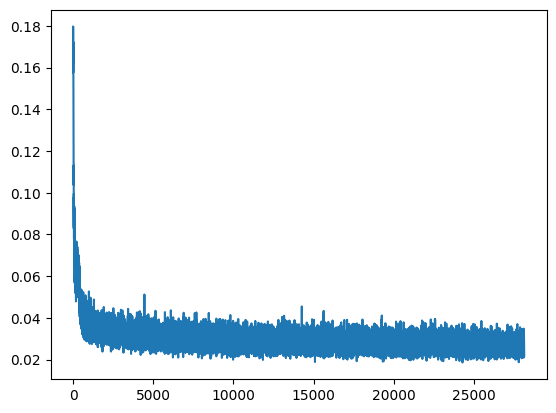

In [11]:
losses = [x.cpu().detach().numpy() for x in losses]
plt.plot(losses)

Results of epoch: 0


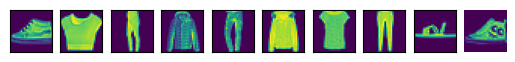

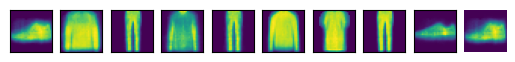

Results of epoch: 1


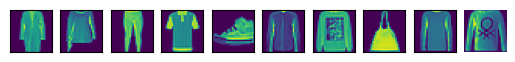

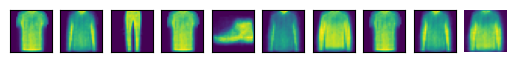

Results of epoch: 2


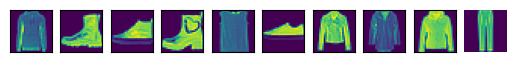

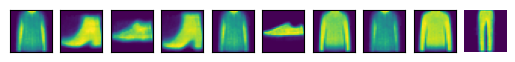

Results of epoch: 3


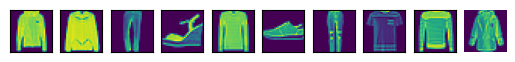

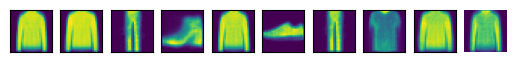

Results of epoch: 4


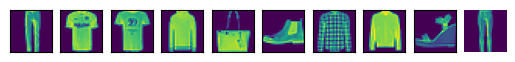

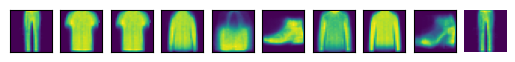

Results of epoch: 5


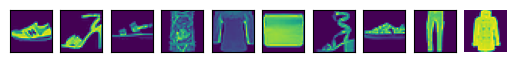

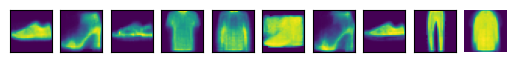

Results of epoch: 6


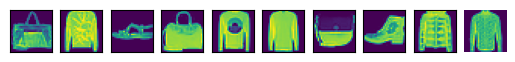

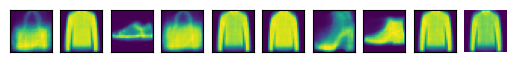

Results of epoch: 7


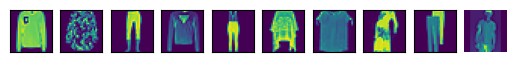

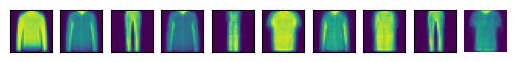

Results of epoch: 8


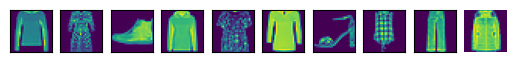

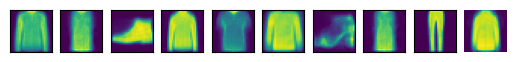

Results of epoch: 9


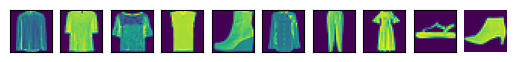

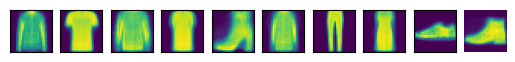

Results of epoch: 10


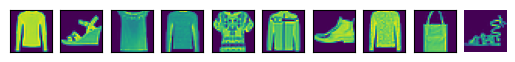

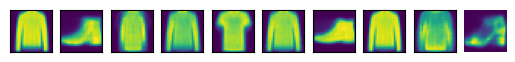

Results of epoch: 11


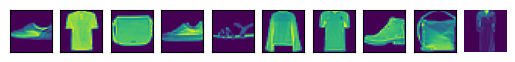

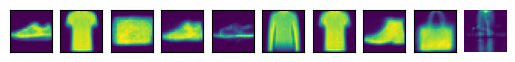

Results of epoch: 12


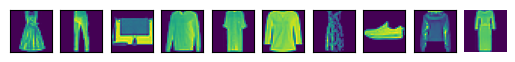

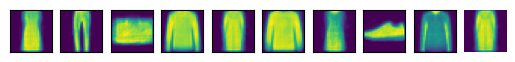

Results of epoch: 13


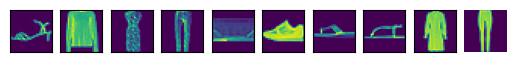

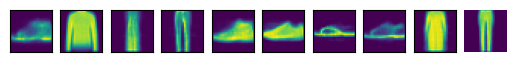

Results of epoch: 14


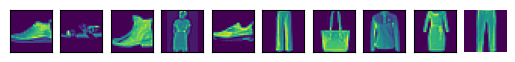

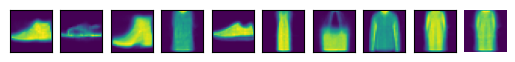

In [12]:
display_reconstr(outputs)

Как видно из реконструкций изображений, в большинстве случаев модель правильно определяет класс изображения, но в очень общем виде восстанавливает объект.

Отобразим на рисунке выход энкодера для всего датасета

  0%|          | 0/60000 [00:00<?, ?it/s]

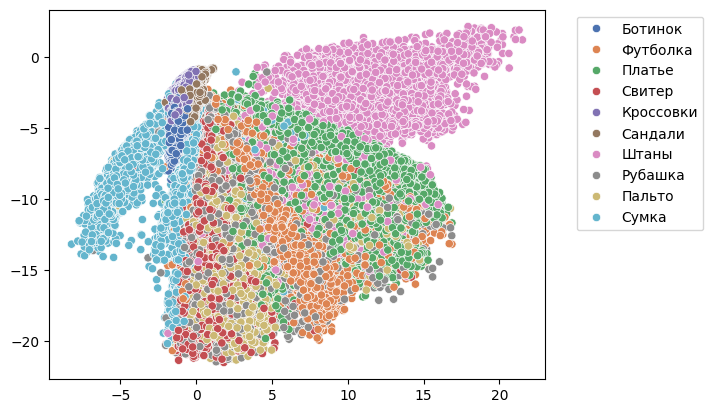

In [13]:
latent_view = []
class_labels = []

for img, label in tqdm(dataset):
    image = img.reshape(-1, 28 * 28)
    image = image.to(device)
    latent = model.encoder(image)
    latent_view.append(latent.cpu().detach().numpy())
    class_labels.append(label)
class_labels_strings = [class_names[x] for x in class_labels]
sns.scatterplot(
    x=[x[0][0] for x in latent_view],
    y=[x[0][1] for x in latent_view],
    hue=class_labels_strings,
    palette="deep",
)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc="upper left")
plt.show()

Интересно, что в латентном пространстве модель более-менее отделяет класс сумок и штанов, остальные классы значительно перемешаны.

# Многослойный автокодировщик 32-мерное латентное пространство + TSNE

Здесь буду использовать модель немного побольше и выхож энкодера уже будет иметь размерность 32

In [14]:
model = AE(sizes=[28 * 28, 512, 256, 128, 64, 32])
model.to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-8)

In [15]:
losses, outputs = train(15, model, loader, loss_function, optimizer)

Working over epoch: 0
Epoch: 0 Loss: 0.16626079380512238
Epoch: 0 Loss: 0.025620630010962486
Working over epoch: 1
Epoch: 1 Loss: 0.01940261758863926
Epoch: 1 Loss: 0.01983398012816906
Working over epoch: 2
Epoch: 2 Loss: 0.01569170132279396
Epoch: 2 Loss: 0.018194371834397316
Working over epoch: 3
Epoch: 3 Loss: 0.0197577066719532
Epoch: 3 Loss: 0.018266530707478523
Working over epoch: 4
Epoch: 4 Loss: 0.014690610580146313
Epoch: 4 Loss: 0.018109284341335297
Working over epoch: 5
Epoch: 5 Loss: 0.01820896379649639
Epoch: 5 Loss: 0.017383737489581108
Working over epoch: 6
Epoch: 6 Loss: 0.01552153006196022
Epoch: 6 Loss: 0.015811216086149216
Working over epoch: 7
Epoch: 7 Loss: 0.01741226762533188
Epoch: 7 Loss: 0.016017192974686623
Working over epoch: 8
Epoch: 8 Loss: 0.014391574077308178
Epoch: 8 Loss: 0.018424658104777336
Working over epoch: 9
Epoch: 9 Loss: 0.013881796970963478
Epoch: 9 Loss: 0.017046894878149033
Working over epoch: 10
Epoch: 10 Loss: 0.015298772603273392
Epoch: 10

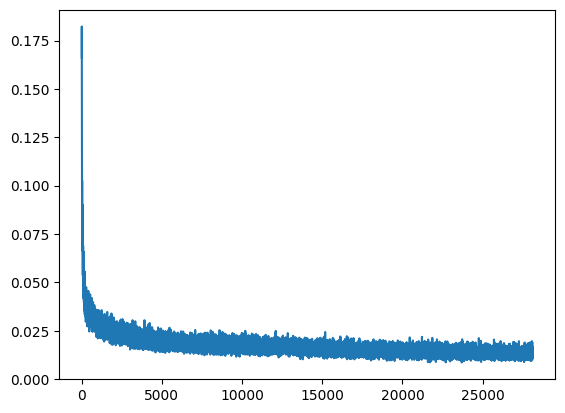

In [16]:
losses = [x.cpu().detach().numpy() for x in losses]
plt.plot(losses)

Results of epoch: 0


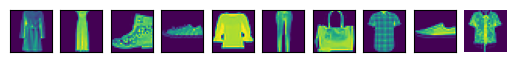

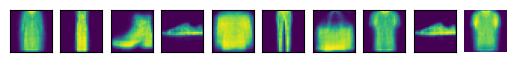

Results of epoch: 1


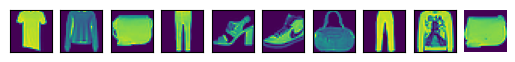

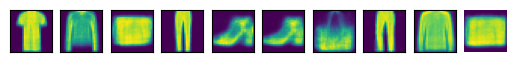

Results of epoch: 2


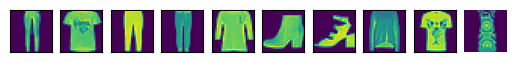

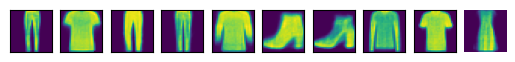

Results of epoch: 3


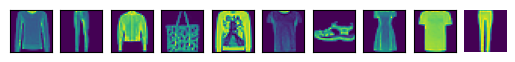

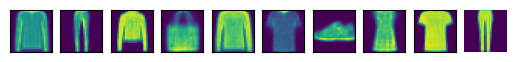

Results of epoch: 4


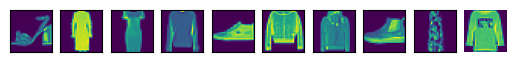

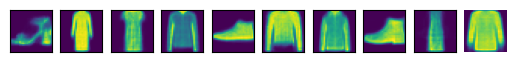

Results of epoch: 5


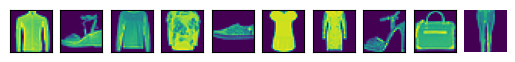

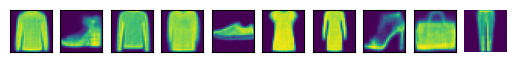

Results of epoch: 6


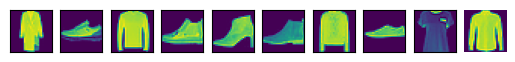

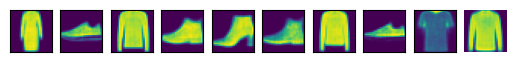

Results of epoch: 7


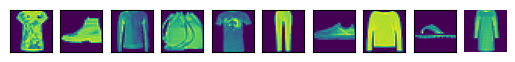

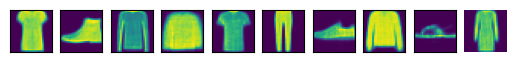

Results of epoch: 8


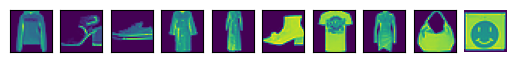

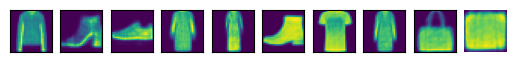

Results of epoch: 9


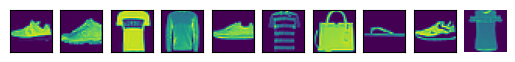

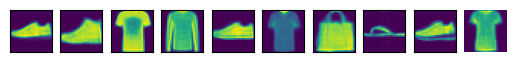

Results of epoch: 10


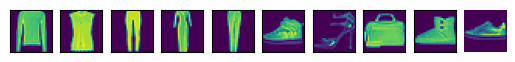

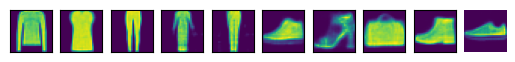

Results of epoch: 11


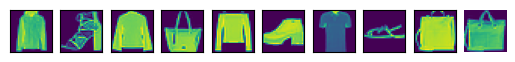

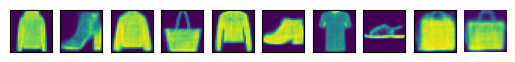

Results of epoch: 12


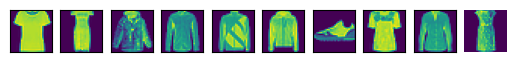

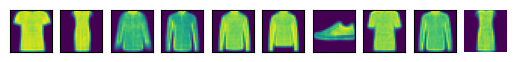

Results of epoch: 13


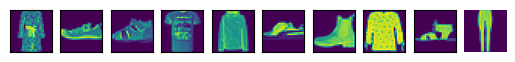

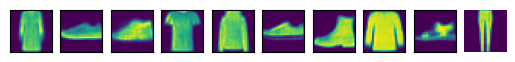

Results of epoch: 14


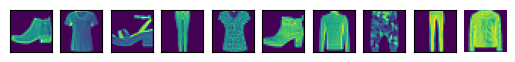

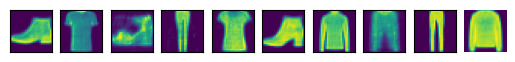

In [17]:
display_reconstr(outputs)

Реконструкции выглядят уже лучше, реже путает классы, хотя какие-то мелкие детали декодер не восстанавливает.
Буду использовать TSNE, чтобы уменьшить размерность выхода энкодера и отобразить его на графике.

  0%|          | 0/60000 [00:00<?, ?it/s]

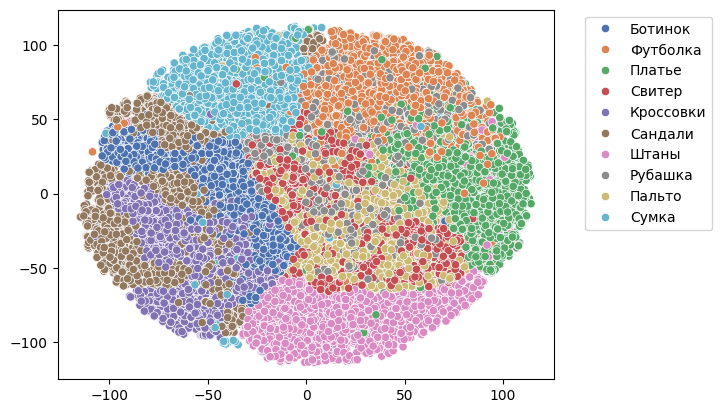

In [18]:
latent_view = []
class_labels = []

for img, label in tqdm(dataset):
    image = img.reshape(-1, 28 * 28)
    image = image.to(device)
    latent = model.encoder(image)
    latent_view.append(latent.cpu().detach().numpy())
    class_labels.append(label)
class_labels_strings = [class_names[x] for x in class_labels]
scaler = StandardScaler().fit([x[0] for x in latent_view])
latent_view_normalized = scaler.transform([x[0] for x in latent_view])

latent_view_reduced = TSNE(
    n_components=2, learning_rate="auto", init="random", perplexity=3
).fit_transform(latent_view_normalized)

sns.scatterplot(
    x=[x[0] for x in latent_view_reduced],
    y=[x[1] for x in latent_view_reduced],
    hue=class_labels_strings,
    palette="deep",
)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc="upper left")
plt.show()

Интересно, что в 32-мерном пространстве больше классов отделены от других: более-менее можно обозначить границы не только сумок и штанов, но отдельно проматриваются различные виды обуви, платье и футболка. Хотя по классам пальто, рубашка и свитер - полная мешанина.
В целом немного большая размерность латентного пространства позволяет лучше разделять классы.

# Шумные автокодировщик - нормальный шум

Класс для изменения изображений при помощи добавления шума

In [19]:
class AddGaussianNoise(object):
    def __init__(self, mean=0.0, std=1.0):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + "(mean={0}, std={1})".format(
            self.mean, self.std
        )

Буду добавлять шум не во все изображения, а лишь с вероятностью 0,7. При этом возьму величину среднего значения 0.8, а стандартного отклонения 0.2. Чем меньше стандартное отклонение, тем меньше шум на изображении.

In [20]:
noisy_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.RandomApply([AddGaussianNoise(0.8, 0.2)], p=0.7),
    ]
)

In [21]:
noisy_dataset = datasets.FashionMNIST(
    root="./data", train=True, download=True, transform=noisy_transform
)
noisy_loader = torch.utils.data.DataLoader(
    dataset=noisy_dataset, batch_size=32, shuffle=True
)

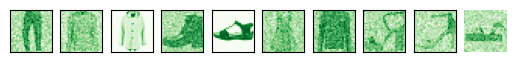

In [23]:
images, labels = next(iter(noisy_loader))

for idx, img in enumerate(images[0:10]):
    plt.subplot(1, 10, idx + 1)
    original_image = img.detach().numpy().copy()
    fig = plt.imshow(original_image.reshape(28, 28), 'Greens')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
plt.axis("off")
plt.show()

In [24]:
model = AE(sizes=[28 * 28, 512, 256, 128, 64, 32])
model.to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-8)

In [25]:
losses, outputs = train(15, model, noisy_loader, loss_function, optimizer)

Working over epoch: 0
Epoch: 0 Loss: 0.4482837915420532
Epoch: 0 Loss: 0.11657111346721649
Working over epoch: 1
Epoch: 1 Loss: 0.15938428044319153
Epoch: 1 Loss: 0.11384207010269165
Working over epoch: 2
Epoch: 2 Loss: 0.11931990087032318
Epoch: 2 Loss: 0.13868001103401184
Working over epoch: 3
Epoch: 3 Loss: 0.1373763084411621
Epoch: 3 Loss: 0.1528007835149765
Working over epoch: 4
Epoch: 4 Loss: 0.12398170679807663
Epoch: 4 Loss: 0.11240915209054947
Working over epoch: 5
Epoch: 5 Loss: 0.13532912731170654
Epoch: 5 Loss: 0.09860560297966003
Working over epoch: 6
Epoch: 6 Loss: 0.11291087418794632
Epoch: 6 Loss: 0.10773789137601852
Working over epoch: 7
Epoch: 7 Loss: 0.12423273921012878
Epoch: 7 Loss: 0.12202037125825882
Working over epoch: 8
Epoch: 8 Loss: 0.11459002643823624
Epoch: 8 Loss: 0.08014698326587677
Working over epoch: 9
Epoch: 9 Loss: 0.1039889007806778
Epoch: 9 Loss: 0.10544253140687943
Working over epoch: 10
Epoch: 10 Loss: 0.1150067001581192
Epoch: 10 Loss: 0.12083687

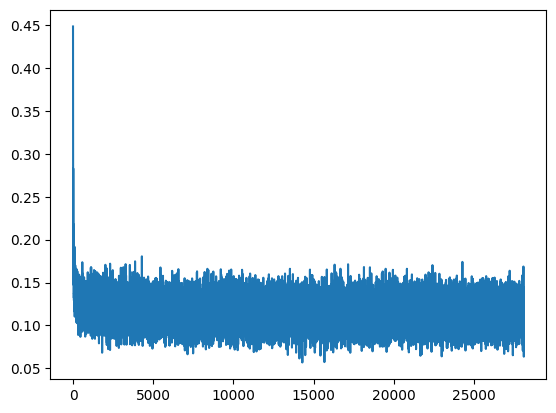

In [26]:
losses = [x.cpu().detach().numpy() for x in losses]
plt.plot(losses)

Results of epoch: 0


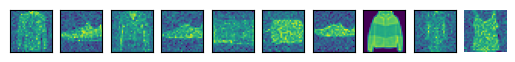

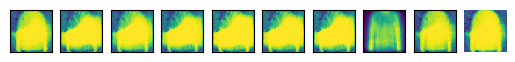

Results of epoch: 1


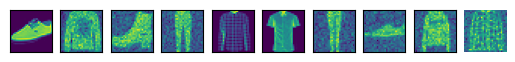

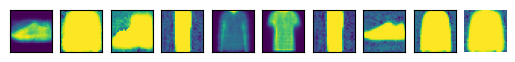

Results of epoch: 2


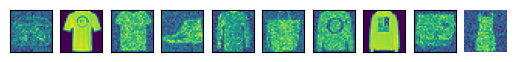

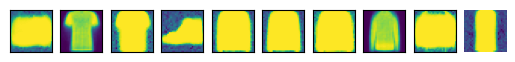

Results of epoch: 3


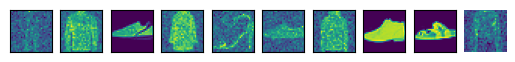

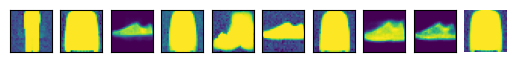

Results of epoch: 4


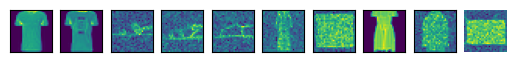

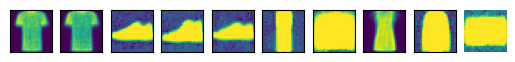

Results of epoch: 5


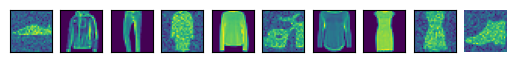

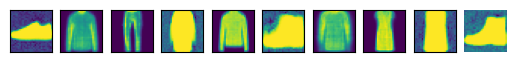

Results of epoch: 6


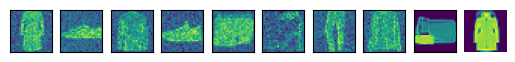

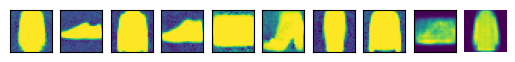

Results of epoch: 7


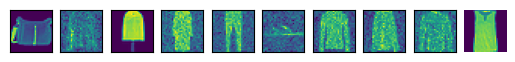

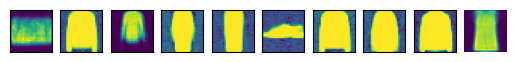

Results of epoch: 8


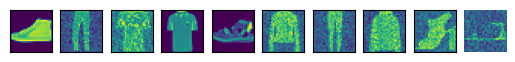

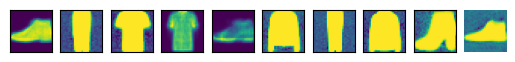

Results of epoch: 9


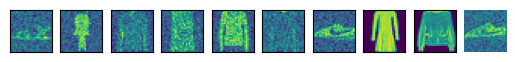

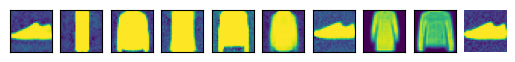

Results of epoch: 10


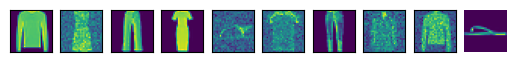

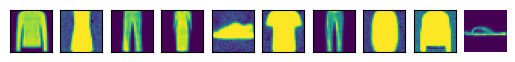

Results of epoch: 11


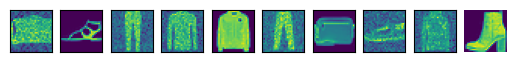

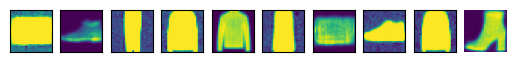

Results of epoch: 12


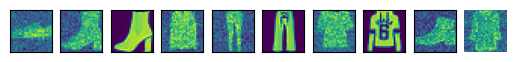

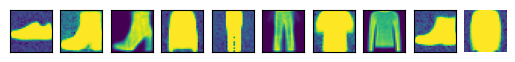

Results of epoch: 13


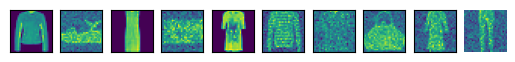

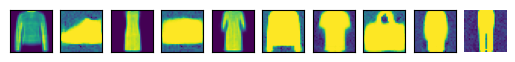

Results of epoch: 14


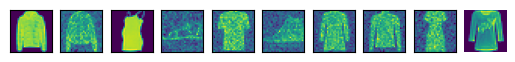

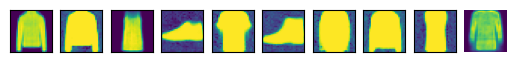

In [27]:
display_reconstr(outputs)

Модель учится хуже, по крайней мере за то же количество эпох, научилась восстанавливать общие классы. Скорее всего нужно немного больше эпох для обучения.

Для отражения карт активации нужно получить выход выбранного слоя, для этого рекомендуют использовать Forward Hooks.

In [28]:
feats = {}
def hook_func(module, input, output):
    feats["feat"] = output.detach()

model.encoder[0].register_forward_hook(hook_func)

Функция для отображения выходов выбранного слоя в виде карт активации

In [29]:
def display_activations(batch_of_images, model, device):
    for idx, img in enumerate(batch_of_images[0:10]):
        plt.subplot(1, 10, idx + 1)
        original_image = img.detach().numpy().copy()
        fig = plt.imshow(original_image.reshape(28, 28), 'Greens')
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
    plt.axis("off")
    plt.show()

    for idx, img in enumerate(batch_of_images[0:10]):
        plt.subplot(1, 10, idx + 1)
        original_image = img.detach().numpy().copy()
        image = img.reshape(-1, 28 * 28)
        output = model(image.to(device))
        activation = feats["feat"].cpu().detach().numpy()
        _, height, width = original_image.shape
        upd_activation = cv2.resize(activation, (width, height))
        #upd_activation = upd_activation.reshape(28, 28)
        upd_activation = np.uint8(255 * upd_activation)
        fig = plt.imshow(upd_activation, "Greens")
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
    plt.axis("off")
    plt.show()

    for idx, img in enumerate(batch_of_images[0:10]):
        plt.subplot(1, 10, idx + 1)
        original_image = img.detach().numpy().copy()
        image = img.reshape(-1, 28 * 28)
        output = model(image.to(device))
        fig = plt.imshow(output.cpu().detach().numpy().reshape(28,28), "Greens")
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
    plt.axis("off")
    plt.show()

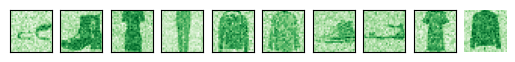

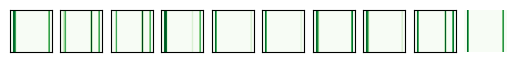

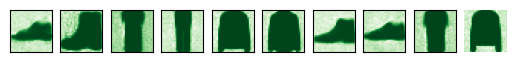

In [30]:
images = next(iter(noisy_loader))[0]
display_activations(images, model, device)

При зушумленном датасете на первом линейном слое энкодера активировано очень мало нейронов.

# Шумный автокодировщик с зеркальным отображением части изображения

Для создания такой обработки создам класс, который будет отображать вертикально часть изображения. В нем установлю mirror_persent = 1, но при использовании randomApply укажу вероятностью применения 0,7

In [31]:
class CustomTransform(object):
    def __init__(self, mirror_percent=1.0):
        self.mirror_percent = mirror_percent

    # Defining the transform method
    def __call__(self, image):
        img_part = np.random.randint(5)
        image = image.reshape(28,28)
        if img_part == 0:
            image[5:25, 5:25] = image[5:25, 5:25].flip(dims=(0,))
        elif img_part == 1:
            image[:14, 14:] = image[:14, 14:].flip(dims=(0,))
        elif img_part == 2:
            image[14:, :14] = image[14:, :14].flip(dims=(0,))
        elif img_part == 3:
            image[14:, 14:] = image[14:, 14:].flip(dims=(0,))
        elif img_part == 4:
            image[7:21, 7:21] = image[7:21, 7:21].flip(dims=(0,))

        return image.unsqueeze(0)

In [32]:
mirror_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.RandomApply([CustomTransform()], p=0.7),
    ]
)

In [33]:
mirror_dataset = datasets.FashionMNIST(
    root="./data", train=True, download=True, transform=mirror_transform
)
mirror_loader = torch.utils.data.DataLoader(
    dataset=mirror_dataset, batch_size=32, shuffle=True
)

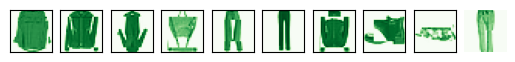

In [34]:
images, labels = next(iter(mirror_loader))

for idx, img in enumerate(images[0:10]):
    plt.subplot(1, 10, idx + 1)
    original_image = img.detach().numpy().copy()
    fig = plt.imshow(original_image.reshape(28,28), "Greens")
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
plt.axis("off")
plt.show()

Да, датасет получился достаточно поврежденным. Посмотрим, что научится восстанавливать модель.

In [35]:
model = AE(sizes=[28 * 28, 512, 256, 128, 64, 32])
model.to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-8)

In [36]:
losses, outputs = train(15, model, mirror_loader, loss_function, optimizer)

Working over epoch: 0
Epoch: 0 Loss: 0.17467206716537476
Epoch: 0 Loss: 0.035619840025901794
Working over epoch: 1
Epoch: 1 Loss: 0.034703031182289124
Epoch: 1 Loss: 0.02988455258309841
Working over epoch: 2
Epoch: 2 Loss: 0.02305474691092968
Epoch: 2 Loss: 0.021996531635522842
Working over epoch: 3
Epoch: 3 Loss: 0.017373226583003998
Epoch: 3 Loss: 0.021880293264985085
Working over epoch: 4
Epoch: 4 Loss: 0.02526392601430416
Epoch: 4 Loss: 0.019733043387532234
Working over epoch: 5
Epoch: 5 Loss: 0.02212551049888134
Epoch: 5 Loss: 0.015728849917650223
Working over epoch: 6
Epoch: 6 Loss: 0.018690291792154312
Epoch: 6 Loss: 0.020332442596554756
Working over epoch: 7
Epoch: 7 Loss: 0.016275936737656593
Epoch: 7 Loss: 0.01873735710978508
Working over epoch: 8
Epoch: 8 Loss: 0.01958792842924595
Epoch: 8 Loss: 0.016686929389834404
Working over epoch: 9
Epoch: 9 Loss: 0.014985940419137478
Epoch: 9 Loss: 0.017442209646105766
Working over epoch: 10
Epoch: 10 Loss: 0.016705920919775963
Epoch: 

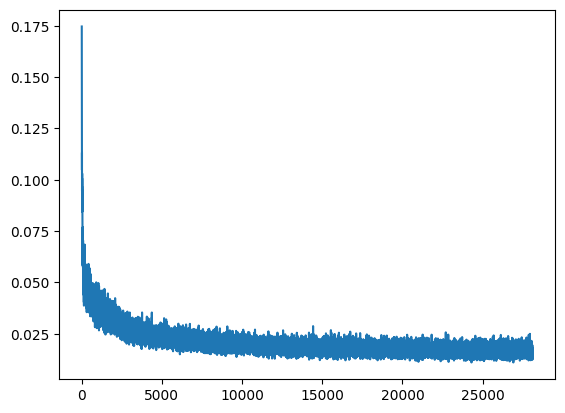

In [37]:
losses = [x.cpu().detach().numpy() for x in losses]
plt.plot(losses)

Results of epoch: 0


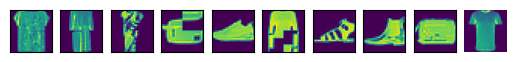

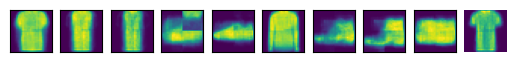

Results of epoch: 1


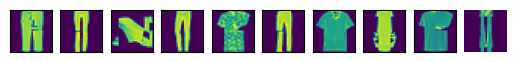

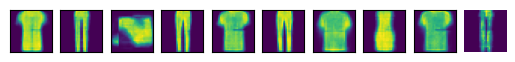

Results of epoch: 2


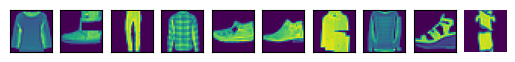

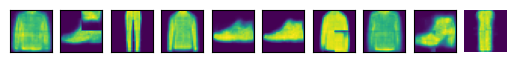

Results of epoch: 3


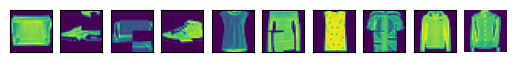

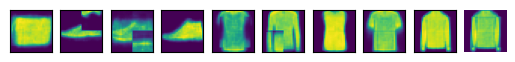

Results of epoch: 4


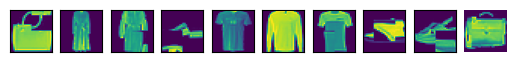

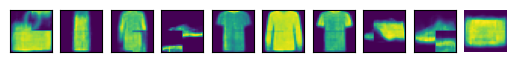

Results of epoch: 5


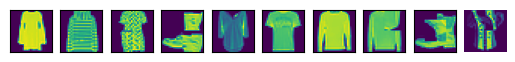

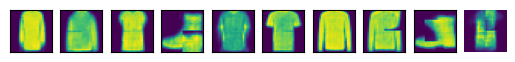

Results of epoch: 6


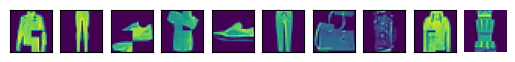

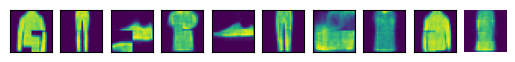

Results of epoch: 7


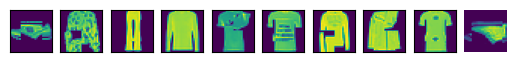

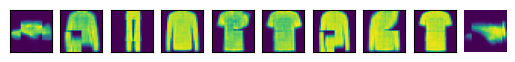

Results of epoch: 8


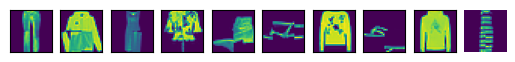

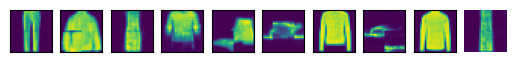

Results of epoch: 9


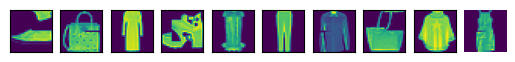

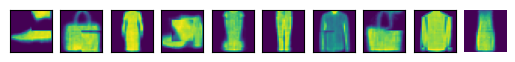

Results of epoch: 10


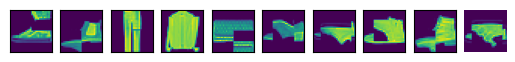

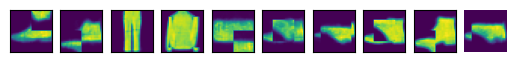

Results of epoch: 11


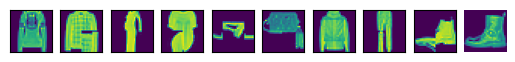

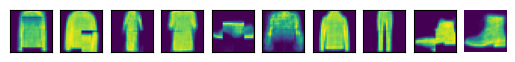

Results of epoch: 12


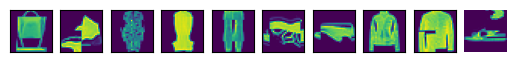

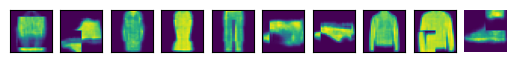

Results of epoch: 13


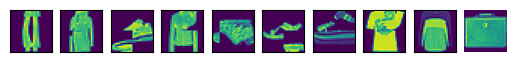

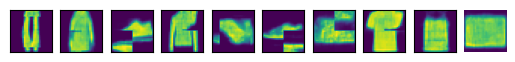

Results of epoch: 14


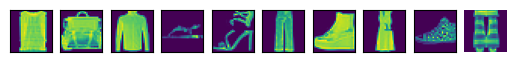

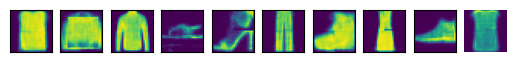

In [38]:
display_reconstr(outputs)

Интересно, модель неплохо учится и восстанавливает исходные поврежденные изображения. Качество реконструкции немногим хуже, чем на изначальных данных, но лучше чем восстановление из шума.

Посмотрим на выходы первого линейного слоя.

In [39]:
model.encoder[0].register_forward_hook(hook_func)

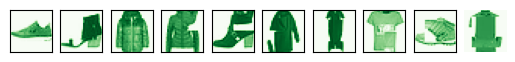

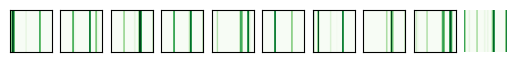

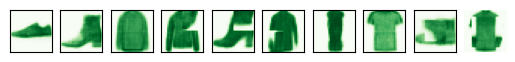

In [40]:
images = next(iter(mirror_loader))[0]
display_activations(images, model, device)

Тоже немного активаций нейронов, но визуально побольше чем при использовании данных с добавлением шума.